In [3]:
import numpy as  np
import pandas as pd

In [4]:
data = pd.read_csv("../data/raw/tokenized_access_logs.csv")

In [5]:
pd.set_option('display.max_columns', None) 
data.head()

,Product,Category,Date,Month,Hour,Department,ip,url
0,adidas Brazuca 2017 Official Match Ball,baseball & softball,9/1/2017 6:00,Sep,6,fitness,37.97.182.65,/department/fitness/category/baseball%20&%20so...
1,The North Face Women's Recon Backpack,hunting & shooting,9/1/2017 6:00,Sep,6,fan shop,206.56.112.1,/department/fan%20shop/category/hunting%20&%20...
2,adidas Kids' RG III Mid Football Cleat,featured shops,9/1/2017 6:00,Sep,6,apparel,215.143.180.0,/department/apparel/category/featured%20shops/...
3,Under Armour Men's Compression EV SL Slide,electronics,9/1/2017 6:00,Sep,6,footwear,206.56.112.1,/department/footwear/category/electronics/prod...
4,Pelican Sunstream 100 Kayak,water sports,9/1/2017 6:01,Sep,6,fan shop,136.108.56.242,/department/fan%20shop/category/water%20sports...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469977 entries, 0 to 469976
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Product     469977 non-null  object
 1   Category    469977 non-null  object
 2   Date        469977 non-null  object
 3   Month       469977 non-null  object
 4   Hour        469977 non-null  int64 
 5   Department  469977 non-null  object
 6   ip          469977 non-null  object
 7   url         469977 non-null  object
dtypes: int64(1), object(7)
memory usage: 28.7+ MB


In [7]:
# Convert Date column to datetime
data["Date"] = pd.to_datetime(data["Date"])

# Verify conversion
data.dtypes

Product               object
Category              object
Date          datetime64[ns]
Month                 object
Hour                   int64
Department            object
ip                    object
url                   object
dtype: object

In [8]:
## Create a GLOBAL demand time series
## How does overall demand change over time?
# Index = time
# Value = number of accesses per hour

# Set Date as index
data_ts = data.set_index("Date")

# Aggregate to hourly demand (recommended syntax)
hourly_demand = data_ts.resample("h").size()

hourly_demand.head()

Date
2017-09-01 06:00:00    150
2017-09-01 07:00:00    150
2017-09-01 08:00:00    162
2017-09-01 09:00:00    150
2017-09-01 10:00:00    144
Freq: h, dtype: int64

In [9]:
hourly_demand.describe() # --> Tells about the Typical demand, Spikes, Variability

count    3666.000000
mean      128.198854
std       260.260090
min         0.000000
25%       129.000000
50%       146.000000
75%       155.000000
max      7735.000000
dtype: float64

1. Converted raw events → signal
2. Chose time granularity
3. Built a stationary candidate series

In [10]:
# What is the time range of the data?

hourly_demand.index.min() , hourly_demand.index.max()

(Timestamp('2017-09-01 06:00:00'), Timestamp('2018-01-31 23:00:00'))

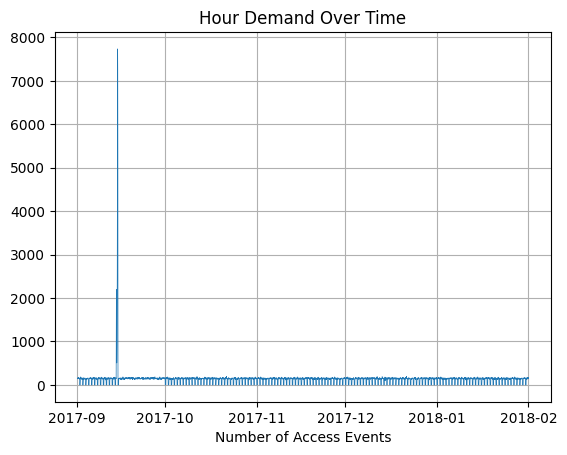

In [11]:
## Plot using graph

import matplotlib.pyplot as plt

plt.plot(hourly_demand, linewidth= 0.5)
plt.title("Hour Demand Over Time")
plt.xlabel("Number of Access Events")
plt.grid(True)
plt.show()

1. The series does not show a long-term trend. It exhibits a clear cyclic (seasonal) pattern with random noise, along with a significant outlier that affects variance and stationarity.
2. Most values are stable around ~100–200
3. One massive spike (~7800) early in the series
4. The mean is mostly stable
5. The variance is NOT stable (that spike breaks it)
6. strictly speaking → NOT stationary

In [12]:
# Check stationarity using (ADF test)

from statsmodels.tsa.stattools import adfuller
result = adfuller(hourly_demand)

print("ADF Statistic:", result[0])
print("P-value :", result[1])

ADF Statistic: -9.390234308367504
P-value : 6.591164471206059e-16


Identifying the outlier problem -> That vertical line is not natural demand behavior.

-> System glitch
-> Batch load
-> Log dump
-> One-time abnormal event

**Interpretation:**

**p ≤ 0.05 → stationary**

**p > 0.05 → non-stationary**

ADF is robust to mean reversion, and a single spike does NOT automatically make a series non-stationary. As per the value the data is stationaly.

Maybe the spike is glich or seasonality or ...........

**Why log1p?**

Handles zeros safely

Standard in demand modeling

What you should observe: --------> Matplotlib 

Spike still exists

BUT no longer dominates

Daily pattern becomes visible

**ACF & PACF on log-transformed series**

Why 72 lags?

24 hours = 1 day

72 = 3 daily cycles

Perfect for hourly data

**In ACF:**

Strong spikes at lag 24, 48, 72

Slow decay

➡️ Confirms seasonality

**In PACF:**

Significant early lags

Helps decide AR terms later

In [13]:
hourly_demand.sort_values(ascending=False).head()

Date
2017-09-14 21:00:00    7735
2017-09-14 20:00:00    7680
2017-09-14 22:00:00    7260
2017-09-14 23:00:00    5310
2017-09-14 19:00:00    4946
dtype: int64

In [14]:
# Log transform the demand

log_hourly_demand = np.log1p(hourly_demand)

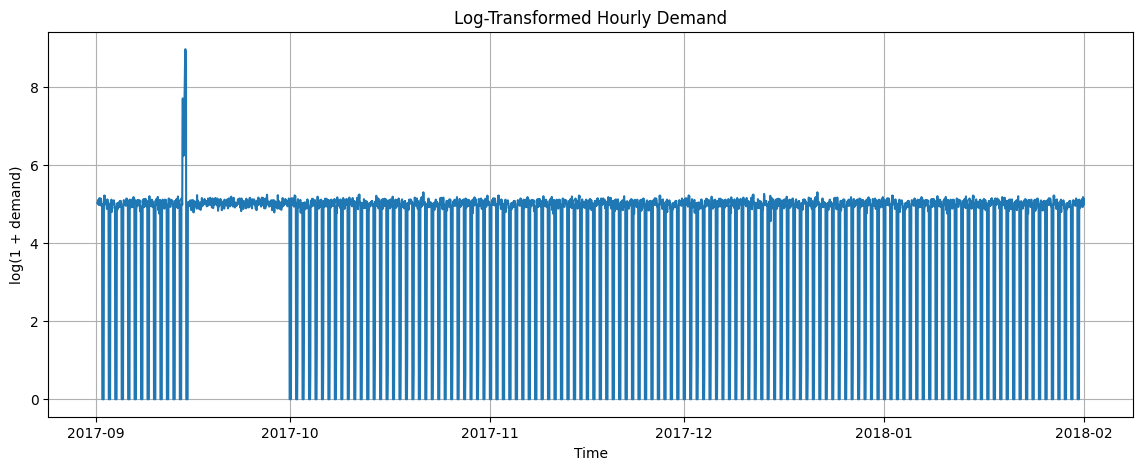

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(log_hourly_demand)
plt.title("Log-Transformed Hourly Demand")
plt.xlabel("Time")
plt.ylabel("log(1 + demand)")
plt.grid(True)
plt.show()

In [16]:
# Run ADF

from statsmodels.tsa.stattools import adfuller 

adf_log = adfuller(log_hourly_demand)
print("ADF statistic:", adf_log[0])
print("p-value:", adf_log[1])

ADF statistic: -3.063219487625611
p-value: 0.02939758202731265


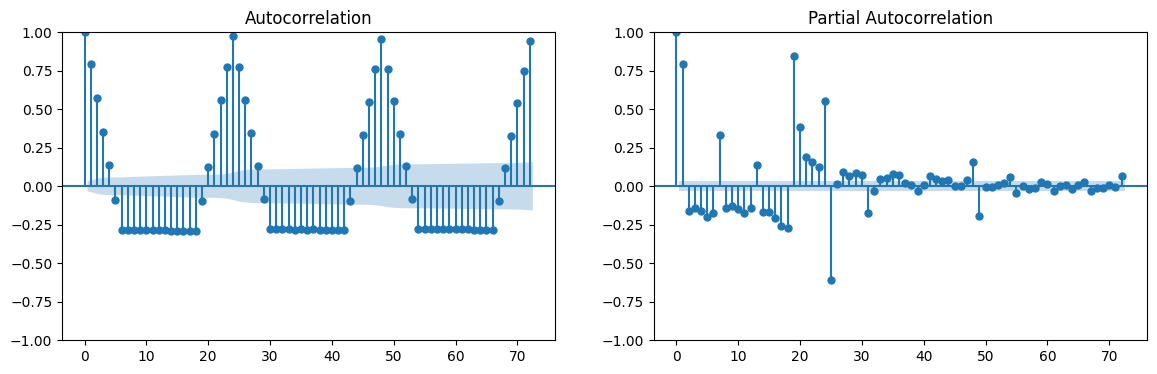

In [31]:
# ACF & PACF on log-transformed series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,4))

plot_acf(log_hourly_demand, lags=72, ax=axes[0])
plot_pacf(log_hourly_demand, lags=72, ax=axes[1])

plt.show()


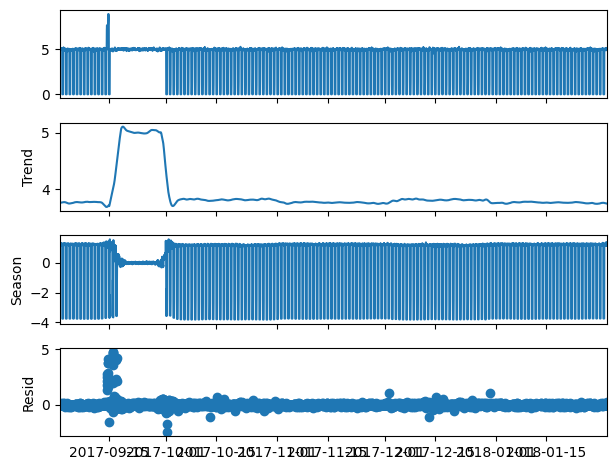

In [21]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

stl = STL(log_hourly_demand, period=24, robust=True)
res = stl.fit()

res.plot()
plt.show()


In [22]:
# SARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    log_hourly_demand,
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = sarima_model.fit(disp=False)

print(sarima_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 3666
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood                 -89.368
Date:                            Tue, 30 Dec 2025   AIC                            188.735
Time:                                    20:51:06   BIC                            219.734
Sample:                                09-01-2017   HQIC                           199.776
                                     - 01-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7812      0.003    272.902      0.000       0.776       0.787
ma.L1         -0.0258      0.007   

Interpretation of your SARIMA output (important)
1️⃣ Model form

SARIMA(1,0,1)(1,0,1,24)
This perfectly matches your diagnostics (ACF/PACF + STL).

2️⃣ Coefficients (very strong)

AR(1) = 0.7812 → strong short-term dependence ✅

MA(1) = -0.0258 → small but significant ✅

Seasonal AR(24) = 0.9946 → VERY strong daily seasonality ✅

Seasonal MA(24) = -0.3633 → strong correction term ✅

All p-values = 0.000 → statistically significant.

👉 This confirms you modeled the structure correctly.

3️⃣ Information criteria

AIC = 188.7

BIC = 219.7

These are reasonable for hourly data.
We only compare these if we try alternative models later.

4️⃣ Residual diagnostics (read this carefully)

Ljung–Box p = 0.87 → ❌ no residual autocorrelation

Heteroskedasticity test p = 0.14 → acceptable

Jarque–Bera p = 0.00 → residuals not normal

⚠️ JB failure is expected here due to:

Outliers

Heavy tails

Log-transformed counts

This is NOT a blocker for forecasting.

5️⃣ Warning message

Covariance matrix calculated using outer product of gradients

✅ Safe to ignore
Very common with large samples + seasonal models.

**Forecasting + confidence intervals**

Now:

Generate forecasts

Convert back from log scale

Visualize uncertainty

Prepare inputs for recommendation logic

In [23]:
# Forecast next 7 days (hourly)

n_steps = 24 * 7  # 7 days

forecast_res = sarima_results.get_forecast(steps=n_steps)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

In [25]:
# Convert back to original scale
forecast_mean_exp = np.expm1(forecast_mean)
lower_ci = np.expm1(forecast_ci.iloc[:, 0])
upper_ci = np.expm1(forecast_ci.iloc[:, 1])

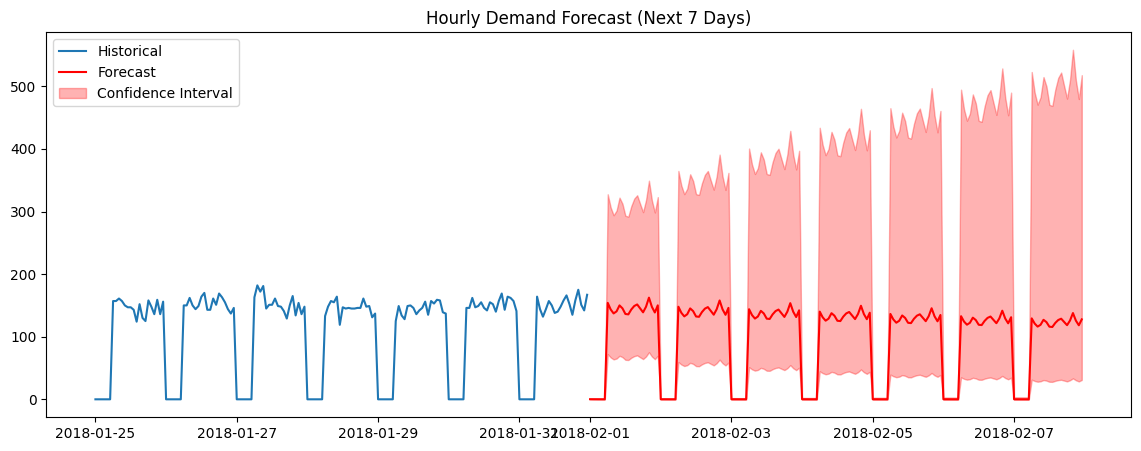

In [26]:
# Plot forecast with uncertainty

plt.figure(figsize=(14,5))

plt.plot(hourly_demand[-7*24:], label="Historical")
plt.plot(forecast_mean_exp, label="Forecast", color="red")
plt.fill_between(
    forecast_mean_exp.index,
    lower_ci,
    upper_ci,
    color="red",
    alpha=0.3,
    label="Confidence Interval"
)

plt.legend()
plt.title("Hourly Demand Forecast (Next 7 Days)")
plt.show()


This is where:

Time series → decision support

Forecast → risk anticipation

Uncertainty → business trade-offs

This directly feeds your recommendation engine.

In [27]:
hourly_demand.index[-1]        # last historical date
forecast_mean_exp.index[0]     # first future (next date)

Timestamp('2018-02-01 00:00:00')

In [29]:
# Create a historical baseline -> Use the recent past (e.g. last 7 days) -> This represents normal demand behavior.

baseline_mean = hourly_demand[-24*7:].mean()
baseline_std  = hourly_demand[-24*7:].std()


In [30]:
# Convert forecast into risk levels

risk_df = forecast_mean_exp.to_frame(name="forecast_demand")
risk_df["z_score"] = (risk_df["forecast_demand"] - baseline_mean) / baseline_std


In [32]:
def risk_level(z):
    if z >= 2:
        return "HIGH"
    elif z >= 1:
        return "MEDIUM"
    else:
        return "LOW"

risk_df["risk_level"] = risk_df["z_score"].apply(risk_level)

In [33]:
# Map risk ➜ action

def recommendation(risk):
    if risk == "HIGH":
        return "Increase capacity / expedite resources"
    elif risk == "MEDIUM":
        return "Monitor closely / partial buffer"
    else:
        return "No action needed"

risk_df["recommendation"] = risk_df["risk_level"].apply(recommendation)